In [1]:
import torch
import numpy as np

import os
os.chdir('..')
from torch_geometric.loader import DataLoader
from gnn_library.util import train, save, load
from evaluate import evaluate_model, pp_output
import instance_generator as ig
import torch_converter as tc
import evaluate as ev
import osmnx as ox
from util import Dataset

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("PyTorch has version {}".format(torch.__version__))
print('Using device:', device)

PyTorch has version 1.12.0+cu102
Using device: cuda:0


In [3]:
args = {
    'processor':         'GENConv',
    'head':              'regression',
    'num_layers':        2,
    'num_mlp_layers':    2,
    'aggr':              'max',
    'batch_size':        32,
    'node_feature_dim':  4,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        64,
    'output_dim':        1,
    'dropout':           0.35,
    'epochs':            25,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.0001,
    'device':            device
}

train_num = 100; test_num = 30

er_config = {
    'graph_type': 'ER',
    'p': 1,
    'weighted': True
}
ba_config = {
    'graph_type': 'BA',
    'ba_param': 2,
    'weighted': True
}
geom_config = {
    'graph_type': 'GEOM',
    'threshold': 0.2,
    'scaling': 1 / np.sqrt(2)
}

rng = np.random.default_rng()


train_instances = [
        *ig.sample_instances(9, 7, train_num, rng, **er_config),
        *ig.sample_instances(9, 7, train_num, rng, **ba_config),
        *ig.sample_instances(9, 7, train_num, rng, **geom_config),
    ]

test_instances = [
        *ig.sample_instances(9, 7, test_num, rng, **er_config),
        *ig.sample_instances(9, 7, test_num, rng, **ba_config),
        *ig.sample_instances(9, 7, test_num, rng, **geom_config),
    ]


train_data = Dataset(tc._instances_to_train_samples(train_instances, args['head']))
test_data = Dataset(tc._instances_to_train_samples(test_instances, args['head']))

train_loader = DataLoader(
    train_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    test_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

In [4]:
_, _, GNN, _ = train(train_loader, test_loader, args)

Training:   0%|          | 0/25 [00:00<?, ?Epochs/s]/home/alexhay/.local/lib/python3.10/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


0.09270249410456553


Training:   4%|▍         | 1/25 [00:03<01:28,  3.67s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.04022132605314255


Training:   8%|▊         | 2/25 [00:06<01:07,  2.95s/Epochs]

0.05023890139415628
0.03616150247782107


Training:  12%|█▏        | 3/25 [00:09<01:10,  3.21s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.01895955763757229


Training:  16%|█▌        | 4/25 [00:12<01:01,  2.92s/Epochs]

0.03035742822434088
0.026108446229165305


Training:  20%|██        | 5/25 [00:15<01:01,  3.09s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.014448091387748718


Training:  24%|██▍       | 6/25 [00:17<00:54,  2.85s/Epochs]

0.023623614405738624
0.021102841385031698


Training:  28%|██▊       | 7/25 [00:21<00:54,  3.03s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.01310906745493412


Training:  32%|███▏      | 8/25 [00:23<00:48,  2.88s/Epochs]

0.020244684367338953
0.019413553730324815


Training:  36%|███▌      | 9/25 [00:27<00:47,  2.98s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.012362548150122166


Training:  40%|████      | 10/25 [00:29<00:42,  2.81s/Epochs]

0.018031863427916267
0.017561818224473162


Training:  44%|████▍     | 11/25 [00:32<00:42,  3.02s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.011288085952401161


Training:  48%|████▊     | 12/25 [00:35<00:36,  2.79s/Epochs]

0.016861126830791683
0.015494288844371172


Training:  52%|█████▏    | 13/25 [00:38<00:35,  2.96s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.010873080231249332


Training:  56%|█████▌    | 14/25 [00:41<00:31,  2.84s/Epochs]

0.015649402543153466
0.015253651732227005


Training:  60%|██████    | 15/25 [00:44<00:29,  2.96s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.010572009719908237


Training:  64%|██████▍   | 16/25 [00:46<00:24,  2.75s/Epochs]

0.014764449444552642
0.014781551558259661


Training:  68%|██████▊   | 17/25 [00:50<00:23,  3.00s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.009678961709141731


Training:  72%|███████▏  | 18/25 [00:52<00:19,  2.85s/Epochs]

0.013736731978052617
0.013455699530447894


Training:  76%|███████▌  | 19/25 [00:56<00:18,  3.05s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.009148688055574894


Training:  80%|████████  | 20/25 [00:58<00:14,  2.88s/Epochs]

0.013203536010181057
0.013185927541071042


Training:  84%|████████▍ | 21/25 [01:02<00:12,  3.04s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.011066797189414501


Training:  88%|████████▊ | 22/25 [01:04<00:08,  2.87s/Epochs]

0.012840224013533089
0.012498346974095088


Training:  92%|█████████▏| 23/25 [01:08<00:06,  3.03s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.009984132833778858


Training:  96%|█████████▌| 24/25 [01:10<00:02,  2.91s/Epochs]

0.01266662621518768
0.012334264575970234


Training: 100%|██████████| 25/25 [01:14<00:00,  2.97s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.013666024431586266


In [5]:
# save(GNN, args, 'GNN3')

In [4]:
GNN, args = load('GNN1', device)

In [29]:
from gnn_library.OBM_greedy import OBM_Greedy
from gnn_library.OBM_threshold_greedy import OBM_Threshold_Greedy

thresholds = np.linspace(0, 1, 101)
thresholded_greedy_models = [(threshold, OBM_Threshold_Greedy(threshold)) for threshold in thresholds]

seed = np.random.randint(0, 500000)
(m, n) = (8, 16)
config = er_config

rng = np.random.default_rng(seed)
eval_instances = ig.sample_instances(m, n, 10, rng, **config)

ratios2 = evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[GNN],
    instances=eval_instances,
    batch_size=50,
    rng=rng,
    num_realizations=5
)

greedy_ratios = {}
for threshold, model in thresholded_greedy_models: 
    ratio = evaluate_model(
        meta_model=None,
        meta_model_type=None,
        base_models=[model],
        instances=eval_instances,
        batch_size=50,
        rng=rng,
        num_realizations=5
    )
    greedy_ratios[threshold] = np.mean(ratio[0])
pp_output(ratios2, _, show_log=False)
print(greedy_ratios)

-- Competitive ratios --
GNN: 0.9636
Greedy: 0.9885
{0.0: 0.9898615618042509, 0.01: 0.9907709910901383, 0.02: 0.9887539926092364, 0.03: 0.9891676274354246, 0.04: 0.9898586878263498, 0.05: 0.990938270845992, 0.06: 0.9904176017204994, 0.07: 0.9899765849853635, 0.08: 0.9880349758723668, 0.09: 0.9879952614274231, 0.1: 0.989681245203079, 0.11: 0.9886036346015852, 0.12: 0.9871217923277287, 0.13: 0.9863221537454058, 0.14: 0.9888654934960949, 0.15: 0.9879433296107477, 0.16: 0.9875422404926317, 0.17: 0.9880758650369629, 0.18: 0.9880700809976964, 0.19: 0.9879087193599798, 0.2: 0.9874323341644633, 0.21: 0.9893074144673001, 0.22: 0.9890345277309092, 0.23: 0.9898226249117947, 0.24: 0.987906312586011, 0.25: 0.9886948340759419, 0.26: 0.9902531917477507, 0.27: 0.9893946399312814, 0.28: 0.9889402699855628, 0.29: 0.9884096584256516, 0.3: 0.9877675846833188, 0.31: 0.9889775818624698, 0.32: 0.9886088165977333, 0.33: 0.9910454797711672, 0.34: 0.989234042940331, 0.35000000000000003: 0.9882749581778839, 0.36

In [30]:
max_threshold = max(greedy_ratios, key = greedy_ratios.get)
print(max_threshold, greedy_ratios[max_threshold])

0.33 0.9910454797711672


# Pivot to feature-generated graphs

In [7]:
def get_location_graph(city):
	location_graph = ox.graph_from_place(city, network_type="drive")
	location_graph = ox.speed.add_edge_speeds(location_graph)
	location_graph = ox.speed.add_edge_travel_times(location_graph)
	return {'location_graph': location_graph, 'city': city}

In [33]:
piedmont = get_location_graph("Piedmont, California, USA")
# san_francisco = get_location_graph("San Francisco, California, USA")
# founex = get_location_graph("Founex, Switzerland")
carmel = get_location_graph("Carmel, Indiana, USA")
geneva = get_location_graph("Geneva, Switzerland")

In [34]:
args = {
    'processor':         'GENConv',
    'head':              'regression',
    'num_layers':        2,
    'num_mlp_layers':    2,
    'aggr':              'max',
    'batch_size':        32,
    'node_feature_dim':  4,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        64,
    'output_dim':        1,
    'dropout':           0.35,
    'epochs':            25,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.0001,
    'device':            device
}

train_num = 100; test_num = 30

er_config = {
    'graph_type': 'ER',
    'p': 1,
    'weighted': True
}
ba_config = {
    'graph_type': 'BA',
    'ba_param': 2,
    'weighted': True
}
feat_config = {
    'graph_type': 'FEAT',
    'q': 0.85,
    'weighted': True
}
osmnx_config = {
    'graph_type': 'OSMNX',
    'location_graph': piedmont['location_graph']
}
# osmnx_config_2 = {
#     'graph_type': 'OSMNX',
#     'location_graph': san_francisco['location_graph']
# }

# ox.plot_graph(piedmont['location_graph'])
# ox.plot_graph(san_francisco['location_graph'])

# part_config = {
# 	'graph_type': 'PART',
#     'p': 0.5,
#     'size': 4,
#     'eps': 0.1
# },
# part_config = {
# 	'graph_type': 'PART',
#     'p': 0.5,
#     'size': 3,
#     'eps': 0.3
# }

rng = np.random.default_rng()


train_instances = [
        *ig.sample_instances(8, 8, train_num, rng, **er_config),
        *ig.sample_instances(8, 8, train_num, rng, **ba_config),
        *ig.sample_instances(8, 8, train_num, rng, **feat_config),
        *ig.sample_instances(8, 8, train_num, rng, **osmnx_config),
        # *ig.sample_instances(8, 8, train_num, rng, **osmnx_config_2),
        # *ig.sample_instances(8, 8, train_num, rng, **feat_config),
        # *ig.sample_instances(8, 8, train_num, rng, **part_config),
    ]

test_instances = [
        *ig.sample_instances(8, 8, test_num, rng, **er_config),
        *ig.sample_instances(8, 8, test_num, rng, **ba_config),
        *ig.sample_instances(8, 8, train_num, rng, **feat_config),
        # *ig.sample_instances(8, 8, train_num, rng, **osmnx_config),
        # *ig.sample_instances(8, 8, train_num, rng, **osmnx_config_2),
        # *ig.sample_instances(8, 8, train_num, rng, **feat_config),
        # *ig.sample_instances(8, 8, train_num, rng, **part_config),
    ]


train_data = Dataset(tc._instances_to_train_samples(train_instances, args['head']))
test_data = Dataset(tc._instances_to_train_samples(test_instances, args['head']))

train_loader = DataLoader(
    train_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    test_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

In [35]:
_, _, GNN, _ = train(train_loader, test_loader, args)

Training:   0%|          | 0/25 [00:00<?, ?Epochs/s]/home/alexhay/.local/lib/python3.10/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


26.36245046865779


Training:   4%|▍         | 1/25 [00:03<01:32,  3.86s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.18171346187591553


Training:   8%|▊         | 2/25 [00:06<01:18,  3.40s/Epochs]

26.78013809762996
24.972991708163846


Training:  12%|█▏        | 3/25 [00:10<01:19,  3.62s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.1109461635351181


Training:  16%|█▌        | 4/25 [00:13<01:10,  3.34s/Epochs]

24.834637763859977
23.44915997677142


Training:  20%|██        | 5/25 [00:17<01:11,  3.59s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.09458737075328827


Training:  24%|██▍       | 6/25 [00:20<01:04,  3.42s/Epochs]

22.793510686841636
22.64736294075656


Training:  28%|██▊       | 7/25 [00:25<01:05,  3.66s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.09537141025066376


Training:  32%|███▏      | 8/25 [00:28<00:58,  3.45s/Epochs]

21.53817344232332
19.419015210694887


Training:  36%|███▌      | 9/25 [00:32<00:59,  3.70s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.09537086635828018


Training:  40%|████      | 10/25 [00:35<00:52,  3.52s/Epochs]

19.517864223462105
19.064407544803306


Training:  44%|████▍     | 11/25 [00:39<00:50,  3.61s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.09808940440416336


Training:  48%|████▊     | 12/25 [00:42<00:44,  3.41s/Epochs]

16.702460377156232
15.046609583761642


Training:  52%|█████▏    | 13/25 [00:46<00:42,  3.58s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.08836336433887482


Training:  56%|█████▌    | 14/25 [00:49<00:37,  3.43s/Epochs]

16.30151928660205
15.540373362804965


Training:  60%|██████    | 15/25 [00:53<00:35,  3.60s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.08701109886169434


Training:  64%|██████▍   | 16/25 [00:56<00:30,  3.40s/Epochs]

12.54254299309683
14.534582973615418


Training:  68%|██████▊   | 17/25 [00:59<00:28,  3.50s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.08755672723054886


Training:  72%|███████▏  | 18/25 [01:02<00:23,  3.31s/Epochs]

12.983817981462824
11.202350237485392


Training:  76%|███████▌  | 19/25 [01:06<00:20,  3.50s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.08882056176662445


Training:  80%|████████  | 20/25 [01:09<00:16,  3.35s/Epochs]

13.796406085272535
12.18659459150835


Training:  84%|████████▍ | 21/25 [01:13<00:14,  3.58s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.09839580208063126


Training:  88%|████████▊ | 22/25 [01:16<00:10,  3.38s/Epochs]

10.736406355845828
9.613575307391706


Training:  92%|█████████▏| 23/25 [01:21<00:07,  3.66s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.08202522248029709


Training:  96%|█████████▌| 24/25 [01:23<00:03,  3.45s/Epochs]

11.800981897706963
8.528481125875158


Training: 100%|██████████| 25/25 [01:27<00:00,  3.51s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.0799504891037941


## Set up the threshold greedy value
The instance set used to determine the threshold should be the same as the training set for the base models. Here we reduce the number of instances to make the evaluation faster.

For the moment, the instance set is the evaluation set since they are too different and would disadvantage threshold greedy.

In [73]:
from tqdm import tqdm
seed = np.random.randint(0, 500000)
rng = np.random.default_rng(seed)


thresholds = np.linspace(0, 1, 101)
#TODO max value in threshold should be max value observable in graphs (is not the case for osmnx graphs for the moment)
thresholded_greedy_models = {threshold: OBM_Threshold_Greedy(threshold) for threshold in thresholds}

osmnx_config1 = {
    'graph_type': 'OSMNX',
    'location_graph': piedmont['location_graph']
}
osmnx_config2 = {
    'graph_type': 'OSMNX',
    'location_graph': geneva['location_graph']
}
osmnx_config3 = {
    'graph_type': 'OSMNX',
    'location_graph': carmel['location_graph']
}

train_num = 10
train_instances = [
        *ig.sample_instances(8, 8, train_num, rng, **osmnx_config1),
        *ig.sample_instances(8, 8, train_num, rng, **osmnx_config2),
        *ig.sample_instances(8, 8, train_num, rng, **osmnx_config3),
]

# train_instances = [
#         *ig.sample_instances(8, 8, train_num, rng, **er_config),
#         *ig.sample_instances(8, 8, train_num, rng, **ba_config),
#         *ig.sample_instances(8, 8, train_num, rng, **feat_config),
#         *ig.sample_instances(8, 8, train_num, rng, **osmnx_config),
# ]


greedy_ratios = {}
for threshold, model in tqdm(thresholded_greedy_models.items()): 
    rng = np.random.default_rng(seed)
    ratio = ev.evaluate_model(
        meta_model=None,
        meta_model_type=None,
        base_models=[model],
        instances=train_instances,
        batch_size=50,
        rng=rng,
        num_realizations=5
    )
    greedy_ratios[threshold] = np.mean(ratio[0])
    

max_threshold = max(greedy_ratios, key = greedy_ratios.get)
print(f"Best threshold value: {max_threshold} achieves CR: {greedy_ratios[max_threshold]}")
THRESHOLD_MODEL = thresholded_greedy_models[max_threshold]

100%|██████████| 101/101 [02:37<00:00,  1.56s/it]

Best threshold value: 0.0 achieves CR: 0.8645662671829395


In [68]:
print(greedy_ratios)

{0.0: 0.8547974821890133, 0.01: 0.8491949417460171, 0.02: 0.8490800453345699, 0.03: 0.8586296980097892, 0.04: 0.8601979868702185, 0.05: 0.8530345227634285, 0.06: 0.8433517994766935, 0.07: 0.8455081071594329, 0.08: 0.8550036958786289, 0.09: 0.8667237837014751, 0.1: 0.8570145658354275, 0.11: 0.8645321197847786, 0.12: 0.8472479172846933, 0.13: 0.8539869854199047, 0.14: 0.8441594970157272, 0.15: 0.8623104023807532, 0.16: 0.8489430822575272, 0.17: 0.8540152834675172, 0.18: 0.8521569526459702, 0.19: 0.84193113171306, 0.2: 0.8401888216372944, 0.21: 0.8567685136103742, 0.22: 0.8528488283873125, 0.23: 0.8635897570505383, 0.24: 0.861469650676488, 0.25: 0.8589468721608017, 0.26: 0.8472143676530135, 0.27: 0.8570897542441344, 0.28: 0.8625095132278946, 0.29: 0.843024730161767, 0.3: 0.8532862706036773, 0.31: 0.8447365797659401, 0.32: 0.848551242272335, 0.33: 0.8432903785767947, 0.34: 0.8636290710672369, 0.35000000000000003: 0.8422966222702438, 0.36: 0.8601692575096457, 0.37: 0.8458496764821762, 0.38:

In [ ]:
seed = np.random.randint(0, 500000)
(m, n) = (32, 16)
# config = {
#     'graph_type': 'FEAT',
#     'q': 0.85,
#     'weighted': True
# }
# config = {
#     'graph_type': 'OSMNX',
#     'location_graph': piedmont['location_graph']
# }
# config = {
# 	'graph_type': 'PART',
#     'p': 0.5,
#     'size': 4,
#     'eps': 0.1
# }

rng = np.random.default_rng(seed)
# eval_instances = ig.sample_instances(m, n, 100, rng, **config)
eval_num = 25
eval_instances = [
        *ig.sample_instances(m, n, eval_num, rng, **er_config),
        *ig.sample_instances(m, n, eval_num, rng, **ba_config),
        *ig.sample_instances(m, n, eval_num, rng, **feat_config),
        *ig.sample_instances(m, n, eval_num, rng, **osmnx_config),
]

ratios2 = ev.evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[GNN],
    instances=eval_instances,
    batch_size=50,
    rng=rng,
    num_realizations=5
)

pp_output(ratios2, _, show_log=False)

-- Competitive ratios --
GNN: 0.8272
Greedy: 0.7817


In [15]:
num_trials = 40
node_configs = [(x, 16) for x in np.arange(4, 64, 4)]
# of nodes [20 -> 80]
# of nodes in batch [10,000 -> 40,000]
batch_size = 500 #[int(min(32, x + y)) for (x, y) in node_configs]
graph_configs = [
    # {
    #     'graph_type': 'GM'
    # },
    # {
    #     'graph_type': 'ER',
    #     'p': 0.75,
    #     'weighted': False
    # },
    # {
    #     'graph_type': 'BA',
    #     'ba_param': 4,
    #     'weighted': False
    # },
    {
        'graph_type': 'FEAT',
        'q': 0.75,
        'weighted': True
    },
    {
        'graph_type': 'FEAT',
        'q': 0.9,
        'weighted': True
    },
    {
        'graph_type': 'FEAT',
        'q': 0.95,
        'weighted': True
    },

    # {
    #     'graph_type': 'PART',
    #     'p': 0.5,
    #     'size': 4,
    #     'eps': 0.1
    # },
    # {
    #     'graph_type': 'PART',
    #     'p': 0.5,
    #     'size': 3,
    #     'eps': 0.3
    # }
]

ratios = [x/y for (x,y) in node_configs]
print(ratios)

data = {config['q']: [] for config in graph_configs}
for graph_config in graph_configs:
    for i, node_config in enumerate(node_configs):
        print(graph_config, node_config)
        seed = np.random.randint(0, 500000)
        rng = np.random.default_rng(seed)
        instances = ig.sample_instances(*node_config, num_trials, rng, **graph_config)


        rng = np.random.default_rng(seed)
        gnn_learned_ratios, greedy_ratios = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[GNN],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5
        )


        data[graph_config['q']].append(np.array(
            [
                gnn_learned_ratios,
                greedy_ratios
            ]
        ))

[0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75]
{'graph_type': 'PART', 'p': 0.5, 'size': 4, 'eps': 0.1} (4, 16)


ValueError: Did not provide required attributes for PART graph type: {'k'}

In [69]:
num_trials = 1
node_configs = [(x, 16) for x in np.arange(4, 64, 4)]
# of nodes [20 -> 80]
# of nodes in batch [10,000 -> 40,000]
batch_size = 500 #[int(min(32, x + y)) for (x, y) in node_configs]




graph_configs = [
    # {
    # 'graph_type': 'FEAT',
    # 'q': 0.5
    # },
    # {
    #     'graph_type': 'OSMNX',
    #     'location_graph': piedmont['location_graph'],
    #     'city': piedmont['city']
    # },
    # {
    #     'graph_type': 'OSMNX',
    #     'location_graph': carmel['location_graph'],
    #     'city': carmel['city']
    # },
    {
        'graph_type': 'OSMNX',
        'location_graph': geneva['location_graph'],
        'city': geneva['city']
    },
    # {
    # 'graph_type': 'FEAT',
    # 'q': 0.75,
    # 'weighted': True
    # },
    # {
    # 'graph_type': 'FEAT',
    # 'q': 0.9,
    # 'weighted': True
    # },
    # {
    # 'graph_type': 'FEAT',
    # 'q': 0.95,
    # 'weighted': True
    # },
    # {
    # 'graph_type': 'FEAT',
    # 'q': 0.99
    # }
    # {
    #     'graph_type': 'PART',
    #     'p': 0.5,
    #     'size': 4,
    #     'eps': 0.1
    # },
    # {
    #     'graph_type': 'PART',
    #     'p': 0.5,
    #     'size': 3,
    #     'eps': 0.3
    # }
]

ratios = [x/y for (x,y) in node_configs]
print(ratios)

data = {config['city']: [] for config in graph_configs}
for graph_config in graph_configs:
    for i, node_config in enumerate(node_configs):
        print(node_config, graph_config)
        seed = np.random.randint(0, 500000)
        rng = np.random.default_rng(seed)
        instances = ig.sample_instances(*node_config, num_trials, rng, **graph_config)


        rng = np.random.default_rng(seed)
        gnn_learned_ratios, greedy_ratios = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[GNN],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5
        )

        thresholded_greedy_ratios, greedy_ratios = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[THRESHOLD_MODEL],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5
        )

        data[graph_config['city']].append(np.array(
            [
                gnn_learned_ratios,
                thresholded_greedy_ratios,
                greedy_ratios
            ]
        ))

[0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75]
(4, 16) {'graph_type': 'OSMNX', 'location_graph': <networkx.classes.multidigraph.MultiDiGraph object at 0x7fd133efc5b0>, 'city': 'Geneva, Switzerland'}
(8, 16) {'graph_type': 'OSMNX', 'location_graph': <networkx.classes.multidigraph.MultiDiGraph object at 0x7fd133efc5b0>, 'city': 'Geneva, Switzerland'}
(12, 16) {'graph_type': 'OSMNX', 'location_graph': <networkx.classes.multidigraph.MultiDiGraph object at 0x7fd133efc5b0>, 'city': 'Geneva, Switzerland'}
(16, 16) {'graph_type': 'OSMNX', 'location_graph': <networkx.classes.multidigraph.MultiDiGraph object at 0x7fd133efc5b0>, 'city': 'Geneva, Switzerland'}
(20, 16) {'graph_type': 'OSMNX', 'location_graph': <networkx.classes.multidigraph.MultiDiGraph object at 0x7fd133efc5b0>, 'city': 'Geneva, Switzerland'}
(24, 16) {'graph_type': 'OSMNX', 'location_graph': <networkx.classes.multidigraph.MultiDiGraph object at 0x7fd133efc5b0>, 'city': 'Geneva, Switzerland'}


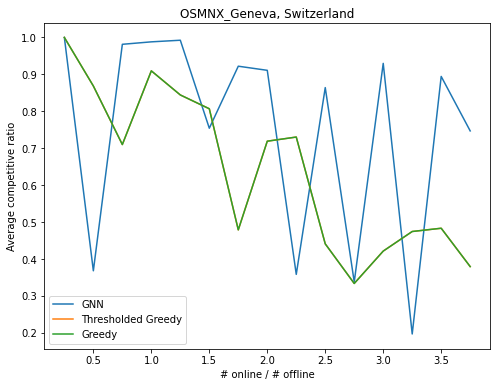

In [70]:
import matplotlib.pyplot as plt
ratios = [x/y for (x,y) in node_configs]
for city, comp_ratios in data.items():
    greedy_avg_ratios = []
    thresholded_greedy_avg_ratios = []
    gnn_avg_ratios = []


    for trial_ratios in comp_ratios:
        gnn_avg_ratios.append(np.array(trial_ratios[0]).mean())
        thresholded_greedy_avg_ratios.append(np.array(trial_ratios[1]).mean())
        greedy_avg_ratios.append(np.array(trial_ratios[2]).mean())

    title = f"OSMNX_{city}"
    fig = plt.figure(figsize=(8,6))
    plt.title(title)
    plt.plot(ratios, gnn_avg_ratios, label='GNN')
    plt.plot(ratios, thresholded_greedy_avg_ratios, label='Thresholded Greedy')
    plt.plot(ratios, greedy_avg_ratios, label='Greedy')
    plt.xlabel('# online / # offline')
    plt.ylabel('Average competitive ratio')
    plt.legend()
    plt.savefig(f"data/{title}.png")
    plt.show()


FEAT_only_ratings_0.75


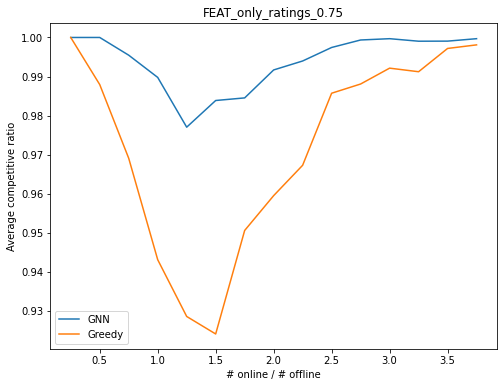

FEAT_only_ratings_0.9


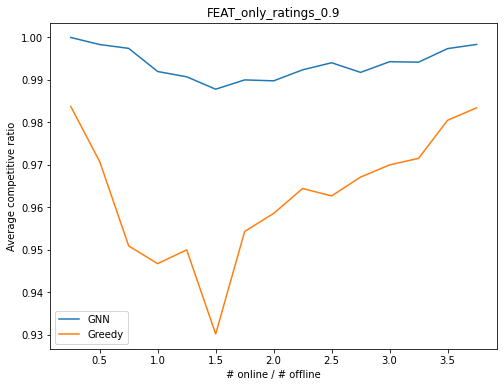

FEAT_only_ratings_0.95


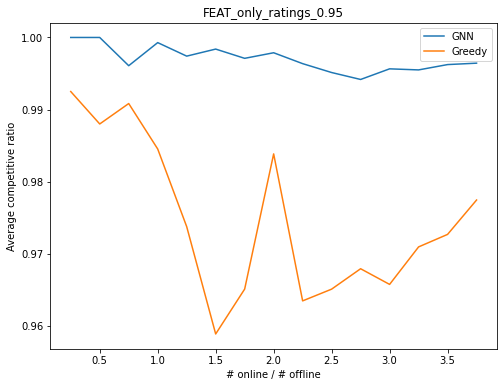

In [9]:
import matplotlib.pyplot as plt
ratios = [x/y for (x,y) in node_configs]
for q, comp_ratios in data.items():
    greedy_avg_ratios = []
    gnn_avg_ratios = []


    for trial_ratios in comp_ratios:
        gnn_avg_ratios.append(np.array(trial_ratios[0]).mean())
        greedy_avg_ratios.append(np.array(trial_ratios[1]).mean())

    # title = f"PART_size_{size}"
    title = f"FEAT_only_ratings_{q}"
    print(title)
    fig = plt.figure(figsize=(8,6))
    plt.title(title)
    plt.plot(ratios, gnn_avg_ratios, label='GNN')
    plt.plot(ratios, greedy_avg_ratios, label='Greedy')
    plt.xlabel('# online / # offline')
    plt.ylabel('Average competitive ratio')
    plt.legend()
    plt.savefig(f"data/{title}.png")
    plt.show()
